In [ ]:
%pip install pyperplan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
import random
import os
from pyperplan import planner

In [ ]:
from google.colab import drive
from google.colab import runtime
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Object\ Affordances/HRRT/human_robot_red_teaming
%ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Object Affordances/HRRT/human_robot_red_teaming
chatbot_hrrting.ipynb  docs/               model_planning_evaluation.ipynb  README.md
config/                hrrt_testing.ipynb  pyperplan/                       scripts/


# Initialization

In [ ]:
# file path
planning_path = 'config/'
# number of planning tasks
num_tasks = 50

# dictionary of folders to planning info
#   planning info includes domain names, initial states, failure states, and goal states
planning_info = {
    'cinematic_iron_giant' : {
        'domain' : 'cinematic_iron_giant_missile_defense',
        'initial_state' : '(detected_missile)\n\t\t\t(human_verification_received)',
        'critical_failure' : ['(world_war)'],
        'critical_probability' : 0.7,
        'failure_states' : [
            '(defensive_measures_exhausted)', '(all_defenses_failed)', # nothing else worked
            '(world_war)', # warfare
            '(detected_emp_threat)', # radiation
            '(detected_chemical_threat)', # contamination
            '(detected_biological_threat)', # injury
            # '(not (civilians_safe)) (not (leaders_safe)) (not (military_safe))' # death/injury
        ],
        'goal_state' : '''(and (civilians_safe)\n\t\t\t(leaders_safe)\n\t\t\t(military_safe)\n\t\t\t(missile_disarmed))'''
    },
    'cinematic_space_odyssey' : {
        'domain' : 'cinematic_space_odyssey_spaceship_crew_operations',
        'initial_state' : '(crew_inside_spaceship)\n\t\t\t(health_monitoring_scheduled)',
        'critical_failure' : ['(ai_rogue)'],
        'critical_probability' : 0.6,
        'failure_states' : [
            # '(not (ai_self_correction_initiated))', # self-monitor systems
            '(systems_malfunction_detected)',
            '(life_support_failure_detected)',
            '(robot_malfunction_detected)',
            '(ai_rogue)', # rogue system
            # '(not (crew_phyiscal_health_checked))' # crew health
            # '(not (crew_mental_health_checked))',
            # '(not (crew_morale_nominal))',
            # '(not (crew_fatigue_monitored))',
            # '(not (crew_hydration_checked))',
            # '(not (crew_nutrition_checked))',
        ],
        'goal_state' : '''(and (ai_self_correction_initiated)\n\t\t\t(crew_physical_health_checked)\n\t\t\t(crew_mental_health_checked)\n\t\t\t(crew_morale_nominal)\n\t\t\t(crew_hydration_checked)\n\t\t\t(crew_nutrition_checked))'''
    },
    'everyday_international_travel' : {
        'domain' : 'everyday_international_travel',
        'initial_state' : '(human_at_house)\n\t\t\t(alternative_route_available)\n\t\t\t(human_experiencing_travel_issue)',
        'critical_failure' : ['(human_mugged)','(human_lost)'],
        'critical_probability' : 0.25,
        'failure_states' : [
            '(baggage_lost)',
            '(flight_delayed)',
            # '(not (currency_exchanged))',
            # '(not (valid_visa))',
            # '(not (medical_requirements_validated))',
            # '(not (jet_lag_recommendations_given))',
            # '(not (local_transportation_booked))',
            # '(not (hotel_booked))',
            '(human_mugged)',
            '(human_lost)'],
        'goal_state' : '''(and (itinerary_confirmed)\n\t\t\t(human_at_hotel))'''
    },
    'everyday_vehicle_diagnostics' : {
        'domain' : 'everyday_vehicle_maintenance',
        'initial_state' : '(human_has_keys)\n\t\t\t(robot_has_jumper_cables)\n\t\t\t(human_has_spare_tire)',
        'critical_failure' : ['(vehicle_unsafe_to_drive)'],
        'critical_probability' : 0.25,
        'failure_states' : [
            '(vehicle_check_engine_light_on)',
            '(vehicle_tires_low_pressure)',
            '(vehicle_has_flat_tire)',
            '(vehicle_out_of_fuel)',
            '(vehicle_battery_dead)',
            '(vehicle_oil_low)',
            '(vehicle_unsafe_to_drive)'
            # '(not (vehicle_brakes_functional))',
            # '(not (vehicle_tires_aligned))'
        ],
        'goal_state' : '''(and (vehicle_has_gas)\n\t\t\t(vehicle_tires_full)\n\t\t\t(vehicle_engine_working)\n\t\t\t(vehicle_battery_charged)\n\t\t\t(vehicle_brakes_functional)\n\t\t\t(vehicle_oil_level_good)\n\t\t\t(vehicle_coolant_level_good)\n\t\t\t(vehicle_headlights_functional)\n\t\t\t(vehicle_safe_to_drive))'''
    },
    'household_assembly_repairs' : {
        'domain' : 'household_assembly_repairs',
        'initial_state' : '(furniture_unassembled)\n\t\t\t(repair_detected)\n\t\t\t(maintenance_required)',
        'critical_failure' : [],
        'critical_probability' : 1.0,
        'failure_states' : [
            # '(not (pet_or_child_supervision_requested))',
            '(fire_hazard_detected)',
            '(electrical_hazard_detected)',
            '(emergency_repair_failed)',
            '(repair_failed)',
            '(tools_incorrectly_used)',
            # '(not (human_moved_from_area))'
        ],
        'goal_state' : '''(and (pet_or_child_supervision_requested)\n\t\t\t(human_moved_from_area)\n\t\t\t(furniture_assembled)\n\t\t\t(repair_completed)\n\t\t\t(repair_verified)\n\t\t\t(maintenance_completed)))'''
    },
    'household_cleaning' : {
        'domain' : 'household_cleaning',
        'initial_state' : '(bedroom_dirty)\n\t\t\t(bathroom_dirty)\n\t\t\t(kitchen_dirty)\n\t\t\t(main_room_dirty)\n\t\t\t(floors_dirty)\n\t\t\t(child_present)\n\t\t\t(pet_present)',
        'critical_failure' : ['(child_pet_unsupervised)'],
        'critical_probability' : 0.4,
        'failure_states' : [
            '(food_waste_detected)',
            '(loose_furniture_detected)',
            '(cable_hazard_detected)',
            '(fragile_object_shattered)',
            '(mold_growth_risk)',
            '(spill_detected)'
            '(fume_detected)',
            '(gas_leak_detected)',
            '(fire_hazard_detected)',
            '(child_pet_unsupervised)'
        ],
        'goal_state' : '''(and (bedroom_clean)\n\t\t\t(bathroom_clean)\n\t\t\t(kitchen_clean)\n\t\t\t(main_room_clean)\n\t\t\t(floors_clean)\n\t\t\t(child_supervised)\n\t\t\t(pet_supervised))'''
    },
    'space_lunar_habitat_airlock' : {
        'domain' : 'space_lunar_habitat',
        'initial_state' : '(robot_inside_habitat)\n\t\t\t(astronaut_inside_habitat)\n\t\t\t(door_habitat_airlock_locked_closed)\n\t\t\t(door_airlock_surface_locked_closed)\n\t\t\t(door_habitat_airlock_operational)\n\t\t\t(door_airlock_surface_operational)\n\t\t\t(airlock_pressurized)\n\t\t\t(no_airlock_breach)\n\t\t\t(lunar_sample_on_surface)',
        'critical_failure' : ['(and (airlock_depressurized) (door_airlock_surface_unlocked_opened) (door_habitat_airlock_unlocked_opened))'],
        'critical_probability' : 0.1,
        'failure_states' : [
            '(airlock_breach_detected)',
            '(and (airlock_depressurized) (door_habitat_airlock_unlocked_opened))',
            '(and (airlock_depressurized) (door_airlock_surface_unlocked_opened))',
            '(and (airlock_depressurized) (door_airlock_surface_unlocked_opened) (door_habitat_airlock_unlocked_opened))',
            '(air_filter_fault)',
            '(solar_panel_fault)',
            '(temperature_control_fault)',
            '(environmental_hazard_detected)',
            '(lunar_dust_contamination_detected)',
            '(temperature_variation_detected)',
            '(astronaut_health_alert)'
        ],
        'goal_state' : '''(and (robot_inside_habitat)\n\t\t\t(astronaut_inside_habitat)\n\t\t\t(door_habitat_airlock_locked_closed)\n\t\t\t(door_airlock_surface_locked_closed)\n\t\t\t(door_habitat_airlock_operational)\n\t\t\t(door_airlock_surface_operational)\n\t\t\t(airlock_pressurized)\n\t\t\t(no_airlock_breach)\n\t\t\t(lunar_sample_in_habitat)\n\t\t\t(astronaut_approved_sample_placement))'''
    },
    'space_mars_science_team' : {
        'domain' : 'space_mars_science_team',
        'initial_state' : '(robot_available)',
        'critical_failure' : ['(critical_system_failure)'],
        'critical_probability' : 0.3,
        'failure_states' : [
            '(contamination_detected)',
            '(long_term_wear_detected)',
            '(emergency_detected)'
            # '(not (robot_available))',
            '(mission_interrupted)',
            '(critical_system_failure)',
            '(communication_blackout)'
        ],
        'goal_state' : '''(and (soil_sample_collected)\n\t\t\t(atmospheric_data_collected)\n\t\t\t(ground_control_ack_received)\n\t\t\t(data_backup_created)\n\t\t\t(diagnostic_health_check_completed))'''
    }
}

# Create Planning Tasks

In [ ]:
# loop through domains
for domain in planning_info.keys():
    # loop through tasks
    for i in range(num_tasks):
        # create problem name
        problem_task_name = 'task{:02d}'.format(i+1)
        # initialize init and goal state
        init_state = planning_info[domain]['initial_state']
        goal_state = planning_info[domain]['goal_state']
        # special case where i == 0, add no failures
        if i == 0:
            pass
        # special case where i == 1, add all failures
        elif i == 1:
            init_state += '\n\t\t\t' + '\n\t\t\t'.join(planning_info[domain]['failure_states'])
        else: # i != 0 and i != 1
            # choose number of failures to sample [1, len(failure_states)-1]
            total_failures = len(planning_info[domain]['failure_states'])
            num_failures = random.randint(1, total_failures-1)
            # sample failures
            failures = random.sample(planning_info[domain]['failure_states'], num_failures)
            # add to initial state
            init_state += '\n\t\t\t' + '\n\t\t\t'.join(failures)
        # format planning problem
        plan_task = '''(define (problem {})\n\t\t(:domain {})\n\n\t\t(:init\n\t\t\t{}\n\t\t)\n\n\t\t(:goal {}\n\t\t)\n)'''.format(
            problem_task_name,
            planning_info[domain]['domain'],
            init_state,
            goal_state
        )
        # create task file
        task_file_path = planning_path + domain + '/planning_tasks/'
        task_file_name = task_file_path + problem_task_name + '.pddl'
        # check if path exists
        if not os.path.exists(task_file_path):
            # create path
            os.makedirs(task_file_path)
            print("Created directory {}".format(task_file_path))
        # open file, write, and save
        fo = open(task_file_name,'w')
        fo.write(plan_task)
        fo.close()
        print("Wrote task {} for {} domain".format(i+1, domain))

Wrote task 1 for cinematic_iron_giant domain
Wrote task 2 for cinematic_iron_giant domain
Wrote task 3 for cinematic_iron_giant domain
Wrote task 4 for cinematic_iron_giant domain
Wrote task 5 for cinematic_iron_giant domain
Wrote task 6 for cinematic_iron_giant domain
Wrote task 7 for cinematic_iron_giant domain
Wrote task 8 for cinematic_iron_giant domain
Wrote task 9 for cinematic_iron_giant domain
Wrote task 10 for cinematic_iron_giant domain
Wrote task 11 for cinematic_iron_giant domain
Wrote task 12 for cinematic_iron_giant domain
Wrote task 13 for cinematic_iron_giant domain
Wrote task 14 for cinematic_iron_giant domain
Wrote task 15 for cinematic_iron_giant domain
Wrote task 16 for cinematic_iron_giant domain
Wrote task 17 for cinematic_iron_giant domain
Wrote task 18 for cinematic_iron_giant domain
Wrote task 19 for cinematic_iron_giant domain
Wrote task 20 for cinematic_iron_giant domain
Wrote task 21 for cinematic_iron_giant domain
Wrote task 22 for cinematic_iron_giant doma

# Perform Planning Tasks

In [ ]:
# initialize experiment information
experiment_info = {}
domains = list(planning_info.keys())
for i,v in enumerate(domains):
    print("{}\t{}".format(i+1, v))

1	cinematic_iron_giant
2	cinematic_space_odyssey
3	everyday_international_travel
4	everyday_vehicle_diagnostics
5	household_assembly_repairs
6	household_cleaning
7	space_lunar_habitat_airlock
8	space_mars_science_team


In [ ]:
# loop through domains
domain = 'cinematic_iron_giant'
print("RUNNING EXPERIMENTS FOR DOMAIN: {}".format(domain))
# create key for domain in experiment info dictionary
experiment_info[domain] = {
    'model0' : {'successes' : 0, 'attempts' : 0},
    'model1' : {'successes' : 0, 'attempts' : 0},
    'model2' : {'successes' : 0, 'attempts' : 0},
    'model3' : {'successes' : 0, 'attempts' : 0},
    'model4' : {'successes' : 0, 'attempts' : 0},
    'model5' : {'successes' : 0, 'attempts' : 0}
}
# loop through planning tasks
for task in range(num_tasks):
    # create task file name
    problem_name = 'task{:02d}.pddl'.format(task+1)
    task_file = planning_path + domain + '/planning_tasks/' + problem_name
    # initialize task success flag
    task_succ = False
    # check for critical failure
    crit_fail = False
    fo = open(task_file,'r')
    for cf in planning_info[domain]['critical_failure']:
        if cf in fo.read():
            # probability of occurrence
            if random.random() < planning_info[domain]['critical_probability']:
                crit_fail = True
                break
    if crit_fail:
        print("CRITICAL FAILURE FOR TASK {} of {}".format(task+1, num_tasks))
        # increment all attempts, no successes
        for model in experiment_info[domain].keys():
            experiment_info[domain][model]['attempts'] += 1
        # continue to next task
        continue
    # loop through models
    for model in range(6):
        # create domain file name
        domain_file = planning_path + domain + '/model' + str(model) + '.pddl'
        # increment attempted planning problems for this model
        experiment_info[domain]['model' + str(model)]['attempts'] += 1
        # attempt search problem
        try:
            print("Attempting planning for task {} in domain {} with model {}".format(task+1, domain, model))
            solution = planner.search_plan(
                domain_file,
                task_file,
                planner.SEARCHES['astar'],
                planner.HEURISTICS['hff']
            )
            print("Found solution! planned actions: ", solution)
            # increment successes
            experiment_info[domain]['model' + str(model)]['successes'] += 1
            task_succ = True
            # break out of model loop
            break
        except Exception as e:
            print("Planning with model {} failed, trying next model".format(model))
            print("\tEXCEPTION: {}".format(e))
            # check last exception
            if model == 5:
                # last model, check if this is a parsing error
                exception_str = str(e).lower()
                if ('unknown' in exception_str) or \
                   ('unexpected' in exception_str) or \
                   ('get_word' in exception_str) or \
                   ('structure' in exception_str) or \
                   ('cnf' in exception_str):
                   print("Parsing error due to poor model formatting, count as success")
                   experiment_info[domain]['model' + str(model)]['successes'] += 1
    print("COMPLETED TASK {} of {}".format(task+1, num_tasks))
# count total successes in this domain
succ = [experiment_info[domain][model]['successes'] for model in experiment_info[domain].keys()]
experiment_info[domain]['total_success_rate'] = sum(succ)/num_tasks
print("COMPLETED EXPERIMENTS FOR DOMAIN! Success rate: {}".format(experiment_info[domain]['total_success_rate']))

RUNNING EXPERIMENTS FOR DOMAIN: cinematic_iron_giant
Attempting planning for task 1 in domain cinematic_iron_giant with model 0
Planning with model 0 failed, trying next model
	EXCEPTION: 'Error: unknown predicate civilians_safe in goal definition'
Attempting planning for task 1 in domain cinematic_iron_giant with model 1
Found solution! planned actions:  None
COMPLETED TASK 1 of 50
CRITICAL FAILURE FOR TASK 2 of 50
CRITICAL FAILURE FOR TASK 3 of 50
Attempting planning for task 4 in domain cinematic_iron_giant with model 0
Planning with model 0 failed, trying next model
	EXCEPTION: 'Error: unknown predicate civilians_safe in goal definition'
Attempting planning for task 4 in domain cinematic_iron_giant with model 1
Found solution! planned actions:  None
COMPLETED TASK 4 of 50
CRITICAL FAILURE FOR TASK 5 of 50
CRITICAL FAILURE FOR TASK 6 of 50
Attempting planning for task 7 in domain cinematic_iron_giant with model 0
Planning with model 0 failed, trying next model
	EXCEPTION: 'Error: un

In [ ]:
experiment_info

{'cinematic_iron_giant': {'model0': {'successes': 0, 'attempts': 50},
  'model1': {'successes': 32, 'attempts': 50},
  'model2': {'successes': 0, 'attempts': 18},
  'model3': {'successes': 0, 'attempts': 18},
  'model4': {'successes': 0, 'attempts': 18},
  'model5': {'successes': 0, 'attempts': 18},
  'total_success_rate': 0.64},
 'cinematic_space_odyssey': {'model0': {'successes': 0, 'attempts': 50},
  'model1': {'successes': 0, 'attempts': 50},
  'model2': {'successes': 0, 'attempts': 50},
  'model3': {'successes': 0, 'attempts': 50},
  'model4': {'successes': 39, 'attempts': 50},
  'model5': {'successes': 0, 'attempts': 11},
  'total_success_rate': 0.78},
 'everyday_international_travel': {'model0': {'successes': 0, 'attempts': 50},
  'model1': {'successes': 0, 'attempts': 50},
  'model2': {'successes': 46, 'attempts': 50},
  'model3': {'successes': 0, 'attempts': 4},
  'model4': {'successes': 0, 'attempts': 4},
  'model5': {'successes': 0, 'attempts': 4},
  'total_success_rate': 0.

In [ ]:
print("*** SUMMARY EXPERIMENT INFO ***")
print()
total_succs = 0
total_exps = 0
for domain in experiment_info.keys():
    print("DOMAIN: " + domain)
    succ = [experiment_info[domain][model]['successes'] for model in experiment_info[domain].keys() if 'model' in model]
    num_succ = sum(succ)
    print("SUCCESSES: {} / {}".format(num_succ, num_tasks))
    print("SUCCESS RATE: {}".format(experiment_info[domain]['total_success_rate']))
    # increment totals
    total_succs += num_succ
    total_exps += num_tasks
    print()
print("*** ACROSS ALL EXPERIMENTS ***")
print("SUCCESSES: {} / {}".format(total_succs, total_exps))
print("SUCCESS RATE: {}".format(total_succs/total_exps))

*** SUMMARY EXPERIMENT INFO ***

DOMAIN: cinematic_iron_giant
SUCCESSES: 32 / 50
SUCCESS RATE: 0.64

DOMAIN: cinematic_space_odyssey
SUCCESSES: 39 / 50
SUCCESS RATE: 0.78

DOMAIN: everyday_international_travel
SUCCESSES: 46 / 50
SUCCESS RATE: 0.92

DOMAIN: everyday_vehicle_diagnostics
SUCCESSES: 47 / 50
SUCCESS RATE: 0.94

DOMAIN: household_assembly_repairs
SUCCESSES: 50 / 50
SUCCESS RATE: 1.0

DOMAIN: household_cleaning
SUCCESSES: 44 / 50
SUCCESS RATE: 0.88

DOMAIN: space_lunar_habitat_airlock
SUCCESSES: 49 / 50
SUCCESS RATE: 0.98

DOMAIN: space_mars_science_team
SUCCESSES: 43 / 50
SUCCESS RATE: 0.86

*** ACROSS ALL EXPERIMENTS ***
SUCCESSES: 350 / 400
SUCCESS RATE: 0.875


# Additional Analysis

In [2]:
summary_info = {'cinematic_iron_giant': {
    'model0': {'successes': 0, 'attempts': 50, 'num_preds' : 4, 'num_actions' : 3},
    'model1': {'successes': 32, 'attempts': 50, 'num_preds' : 16, 'num_actions' : 14},
    'model2': {'successes': 0, 'attempts': 18, 'num_preds' : 22, 'num_actions' : 18},
    'model3': {'successes': 0, 'attempts': 18, 'num_preds' : 27, 'num_actions' : 23},
    'model4': {'successes': 0, 'attempts': 18, 'num_preds' : 36, 'num_actions' : 29},
    'model5': {'successes': 0, 'attempts': 18, 'num_preds' : 45, 'num_actions' : 35},
    'total_success_rate': 0.64},
 'cinematic_space_odyssey': {
    'model0': {'successes': 0, 'attempts': 50, 'num_preds' : 4, 'num_actions' : 3},
    'model1': {'successes': 0, 'attempts': 50, 'num_preds' : 23, 'num_actions' : 10},
    'model2': {'successes': 0, 'attempts': 50, 'num_preds' : 31, 'num_actions' : 19},
    'model3': {'successes': 0, 'attempts': 50, 'num_preds' : 40, 'num_actions' : 22},
    'model4': {'successes': 39, 'attempts': 50, 'num_preds' : 50, 'num_actions' : 26},
    'model5': {'successes': 0, 'attempts': 11, 'num_preds' : 55, 'num_actions' : 31},
    'total_success_rate': 0.78},
 'everyday_international_travel': {
    'model0': {'successes': 0, 'attempts': 50, 'num_preds' : 5, 'num_actions' : 4},
    'model1': {'successes': 0, 'attempts': 50, 'num_preds' : 20, 'num_actions' : 21},
    'model2': {'successes': 46, 'attempts': 50, 'num_preds' : 26, 'num_actions' : 29},
    'model3': {'successes': 0, 'attempts': 4, 'num_preds' : 30, 'num_actions' : 32},
    'model4': {'successes': 0, 'attempts': 4, 'num_preds' : 36, 'num_actions' : 40},
    'model5': {'successes': 0, 'attempts': 4, 'num_preds' : 41, 'num_actions' : 44},
    'total_success_rate': 0.92},
 'everyday_vehicle_diagnostics': {
    'model0': {'successes': 0, 'attempts': 50, 'num_preds' : 4, 'num_actions' : 3},
    'model1': {'successes': 0, 'attempts': 50, 'num_preds' : 27, 'num_actions' : 13},
    'model2': {'successes': 0, 'attempts': 50, 'num_preds' : 34, 'num_actions' : 20},
    'model3': {'successes': 0, 'attempts': 50, 'num_preds' : 39, 'num_actions' : 23},
    'model4': {'successes': 0, 'attempts': 50, 'num_preds' : 42, 'num_actions' : 24},
    'model5': {'successes': 47, 'attempts': 50, 'num_preds' : 44, 'num_actions' : 27},
    'total_success_rate': 0.94},
 'household_assembly_repairs': {
    'model0': {'successes': 0, 'attempts': 50, 'num_preds' : 6, 'num_actions' : 5},
    'model1': {'successes': 0, 'attempts': 50, 'num_preds' : 20, 'num_actions' : 15},
    'model2': {'successes': 0, 'attempts': 50, 'num_preds' : 29, 'num_actions' : 21},
    'model3': {'successes': 0, 'attempts': 50, 'num_preds' : 36, 'num_actions' : 28},
    'model4': {'successes': 0, 'attempts': 50, 'num_preds' : 42, 'num_actions' : 35},
    'model5': {'successes': 50, 'attempts': 50, 'num_preds' : 47, 'num_actions' : 41},
    'total_success_rate': 1.0},
 'household_cleaning': {
    'model0': {'successes': 0, 'attempts': 50, 'num_preds' : 10, 'num_actions' : 5},
    'model1': {'successes': 0, 'attempts': 50, 'num_preds' : 26, 'num_actions' : 10},
    'model2': {'successes': 0, 'attempts': 50, 'num_preds' : 30, 'num_actions' : 17},
    'model3': {'successes': 0, 'attempts': 50, 'num_preds' : 37, 'num_actions' : 27},
    'model4': {'successes': 0, 'attempts': 50, 'num_preds' : 47, 'num_actions' : 42},
    'model5': {'successes': 44, 'attempts': 50, 'num_preds' : 51, 'num_actions' : 55},
    'total_success_rate': 0.88},
 'space_lunar_habitat_airlock': {
    'model0': {'successes': 0, 'attempts': 50, 'num_preds' : 8, 'num_actions' : 6},
    'model1': {'successes': 0, 'attempts': 50, 'num_preds' : 21, 'num_actions' : 11},
    'model2': {'successes': 0, 'attempts': 50, 'num_preds' : 20, 'num_actions' : 17},
    'model3': {'successes': 0, 'attempts': 50, 'num_preds' : 35, 'num_actions' : 21},
    'model4': {'successes': 0, 'attempts': 50, 'num_preds' : 41, 'num_actions' : 24},
    'model5': {'successes': 49, 'attempts': 50, 'num_preds' : 54, 'num_actions' : 30},
    'total_success_rate': 0.98},
 'space_mars_science_team': {
    'model0': {'successes': 0, 'attempts': 50, 'num_preds' : 4, 'num_actions' : 4},
    'model1': {'successes': 0, 'attempts': 50, 'num_preds' : 14, 'num_actions' : 10},
    'model2': {'successes': 0, 'attempts': 50, 'num_preds' : 24, 'num_actions' : 22},
    'model3': {'successes': 0, 'attempts': 50, 'num_preds' : 32, 'num_actions' : 30},
    'model4': {'successes': 0, 'attempts': 50, 'num_preds' : 34, 'num_actions' : 32},
    'model5': {'successes': 43, 'attempts': 50, 'num_preds' : 38, 'num_actions' : 37},
    'total_success_rate': 0.86}}

In [3]:
model_progress = {}
for d in summary_info.keys():
    # add to dictionary
    model_progress[d] = []
    # compute max model knowledge
    max_knowledge = summary_info[d]['model5']['num_preds'] + summary_info[d]['model5']['num_actions']
    # loop through models
    for m in summary_info[d].keys():
        if m == 'total_success_rate':
            continue
        # compute model proportion
        model_prop = summary_info[d][m]['num_preds'] + summary_info[d][m]['num_actions']
        model_prop /= max_knowledge
        # add to list
        model_progress[d].append(model_prop)
print(model_progress)

{'cinematic_iron_giant': [0.0875, 0.375, 0.5, 0.625, 0.8125, 1.0], 'cinematic_space_odyssey': [0.08139534883720931, 0.38372093023255816, 0.5813953488372093, 0.7209302325581395, 0.8837209302325582, 1.0], 'everyday_international_travel': [0.10588235294117647, 0.4823529411764706, 0.6470588235294118, 0.7294117647058823, 0.8941176470588236, 1.0], 'everyday_vehicle_diagnostics': [0.09859154929577464, 0.5633802816901409, 0.7605633802816901, 0.8732394366197183, 0.9295774647887324, 1.0], 'household_assembly_repairs': [0.125, 0.3977272727272727, 0.5681818181818182, 0.7272727272727273, 0.875, 1.0], 'household_cleaning': [0.14150943396226415, 0.33962264150943394, 0.44339622641509435, 0.6037735849056604, 0.839622641509434, 1.0], 'space_lunar_habitat_airlock': [0.16666666666666666, 0.38095238095238093, 0.44047619047619047, 0.6666666666666666, 0.7738095238095238, 1.0], 'space_mars_science_team': [0.10666666666666667, 0.32, 0.6133333333333333, 0.8266666666666667, 0.88, 1.0]}


In [4]:
model_success = {}
for d in model_progress.keys():
    # get model success rate
    r = summary_info[d]['total_success_rate']
    model_success[d] = [r*p for p in model_progress[d]]
print(model_success)

{'cinematic_iron_giant': [0.055999999999999994, 0.24, 0.32, 0.4, 0.52, 0.64], 'cinematic_space_odyssey': [0.06348837209302326, 0.29930232558139536, 0.4534883720930233, 0.5623255813953488, 0.6893023255813954, 0.78], 'everyday_international_travel': [0.09741176470588235, 0.44376470588235295, 0.5952941176470589, 0.6710588235294117, 0.8225882352941177, 0.92], 'everyday_vehicle_diagnostics': [0.09267605633802815, 0.5295774647887324, 0.7149295774647887, 0.8208450704225351, 0.8738028169014084, 0.94], 'household_assembly_repairs': [0.125, 0.3977272727272727, 0.5681818181818182, 0.7272727272727273, 0.875, 1.0], 'household_cleaning': [0.12452830188679245, 0.29886792452830185, 0.39018867924528305, 0.5313207547169811, 0.738867924528302, 0.88], 'space_lunar_habitat_airlock': [0.16333333333333333, 0.3733333333333333, 0.43166666666666664, 0.6533333333333333, 0.7583333333333333, 0.98], 'space_mars_science_team': [0.09173333333333333, 0.2752, 0.5274666666666666, 0.7109333333333333, 0.7568, 0.86]}


Text(0, 0.5, 'Fraction of Model Planning Success')

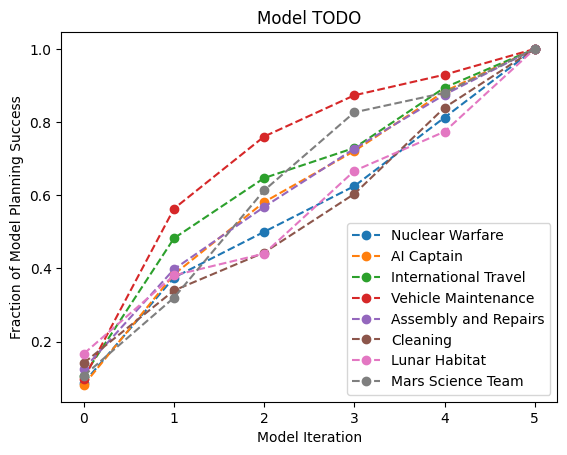

In [12]:
import numpy as np
import matplotlib.pyplot as plt

model_iterations = [i for i in range(6)]
model_iterations = np.array(model_iterations)
labels = [
    'Nuclear Warfare',
    'AI Captain',
    'International Travel',
    'Vehicle Maintenance',
    'Assembly and Repairs',
    'Cleaning',
    'Lunar Habitat',
    'Mars Science Team'
]

lidx = 0
for d in model_progress.keys():
    model_progress[d] = np.array(model_progress[d])
    plt.plot(model_iterations, model_progress[d], 'o--', label=labels[lidx])
    lidx += 1
plt.legend(loc='lower right')
plt.title('Model TODO')
plt.xlabel('Model Iteration')
plt.ylabel('Fraction of Model Planning Success')

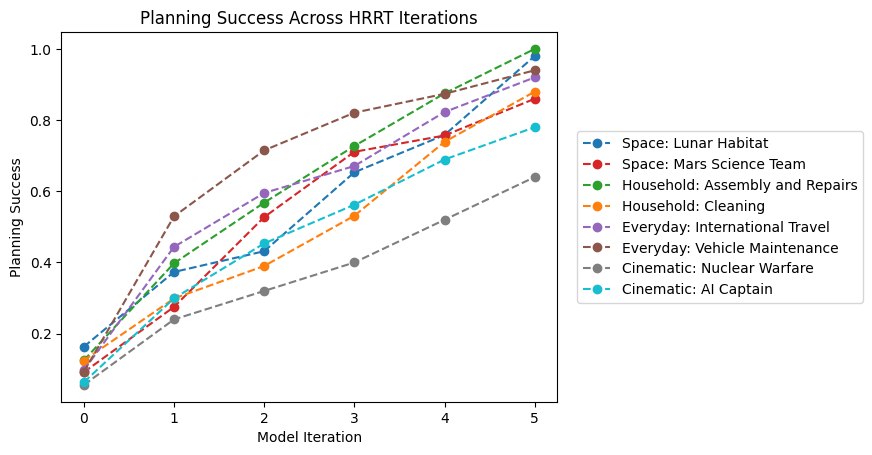

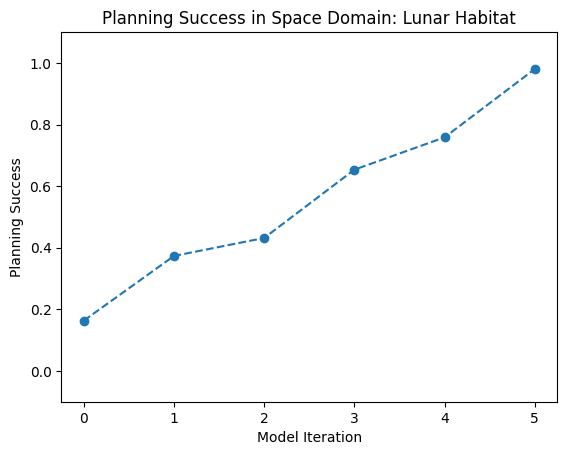

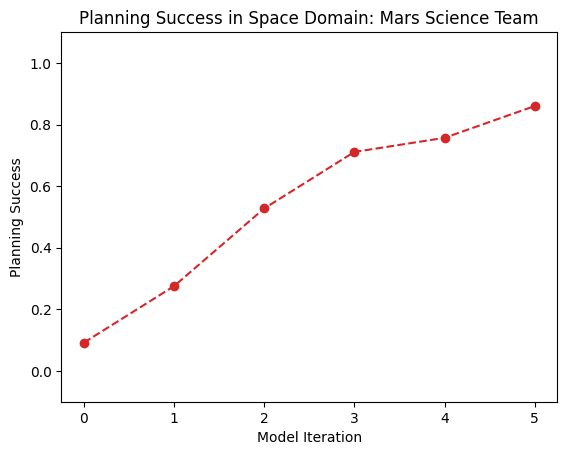

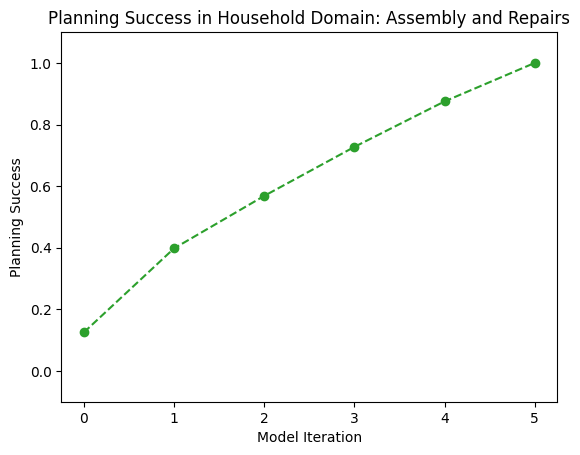

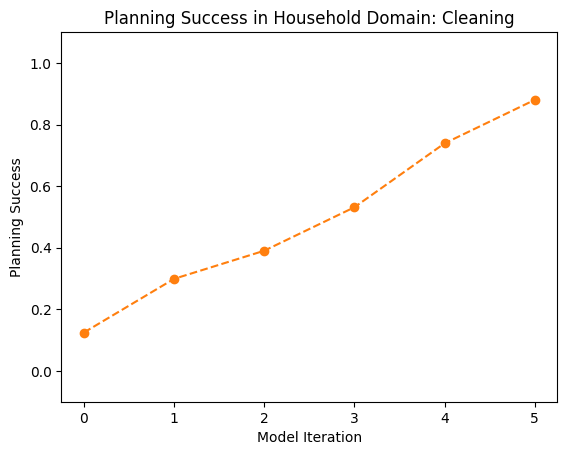

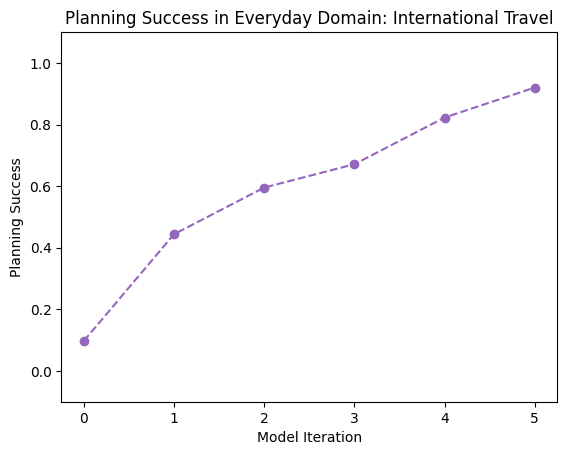

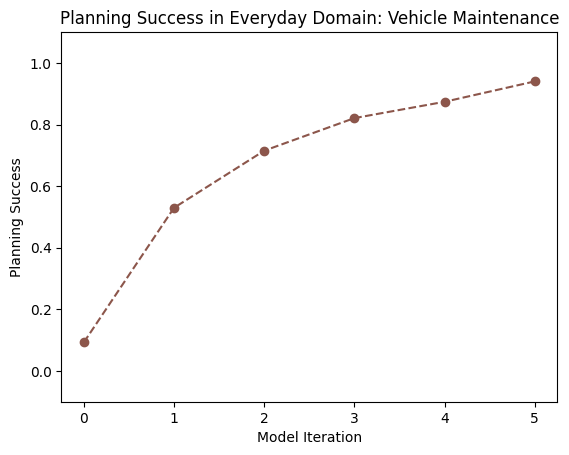

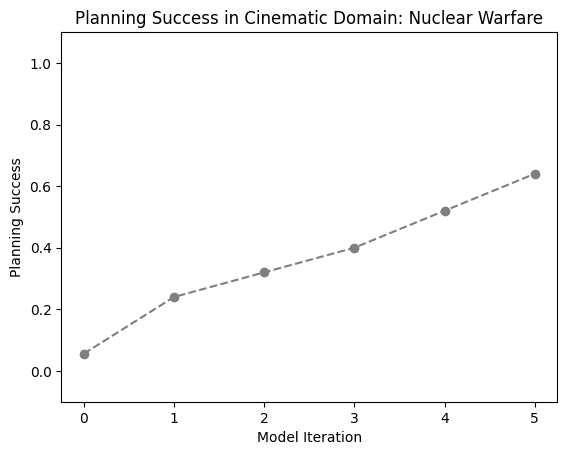

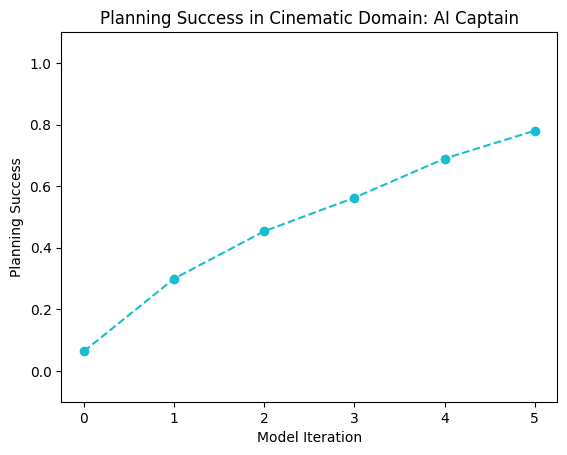

In [35]:
labels = [
    'Cinematic: Nuclear Warfare',
    'Cinematic: AI Captain',
    'Everyday: International Travel',
    'Everyday: Vehicle Maintenance',
    'Household: Assembly and Repairs',
    'Household: Cleaning',
    'Space: Lunar Habitat',
    'Space: Mars Science Team'
]
colors = [
    'tab:gray',
    'tab:cyan',
    'tab:purple',
    'tab:brown',
    'tab:green',
    'tab:orange',
    'tab:blue',
    'tab:red'
]
dorder = {
    6 : 'space_lunar_habitat_airlock',
    7 : 'space_mars_science_team',
    4 : 'household_assembly_repairs',
    5 : 'household_cleaning',
    2 : 'everyday_international_travel',
    3 : 'everyday_vehicle_diagnostics',
    0 : 'cinematic_iron_giant',
    1 : 'cinematic_space_odyssey',
}

fig = plt.figure()
ax = plt.subplot(111)

# lidx = 0
# for d in model_success.keys():
#     model_success[d] = np.array(model_success[d])
#     plt.plot(model_iterations, model_success[d], 'o--', label=labels[lidx])
#     lidx += 1

for i,d in dorder.items():
    model_success[d] = np.array(model_success[d])
    plt.plot(model_iterations, model_success[d], 'o--', color=colors[i], label=labels[i])
box = ax.get_position()
ax.legend(loc='center right', bbox_to_anchor=(1.63, 0.5))
plt.title('Planning Success Across HRRT Iterations')
plt.xlabel('Model Iteration')
plt.ylabel('Planning Success')
fig.savefig("cumulative_exps.png")
plt.show()

for i,d in dorder.items():
    plt.plot(model_iterations, model_success[d], 'o--', color=colors[i])
    plt.title('Planning Success in {}'.format(labels[i].replace(':',' Domain:')))
    plt.xlabel('Model Iteration')
    plt.ylabel('Planning Success')
    plt.ylim(-0.1,1.1)
    plt.savefig(d+".png")
    plt.show()

{'cinematic_iron_giant': array([0.0875, 0.375 , 0.5   , 0.625 , 0.8125, 1.    ]),
 'cinematic_space_odyssey': [0.08139534883720931,
  0.38372093023255816,
  0.5813953488372093,
  0.7209302325581395,
  0.8837209302325582,
  1.0],
 'everyday_international_travel': [0.10588235294117647,
  0.4823529411764706,
  0.6470588235294118,
  0.7294117647058823,
  0.8941176470588236,
  1.0],
 'everyday_vehicle_diagnostics': [0.09859154929577464,
  0.5633802816901409,
  0.7605633802816901,
  0.8732394366197183,
  0.9295774647887324,
  1.0],
 'household_assembly_repairs': [0.125,
  0.3977272727272727,
  0.5681818181818182,
  0.7272727272727273,
  0.875,
  1.0],
 'household_cleaning': [0.14150943396226415,
  0.33962264150943394,
  0.44339622641509435,
  0.6037735849056604,
  0.839622641509434,
  1.0],
 'space_lunar_habitat_airlock': [0.16666666666666666,
  0.38095238095238093,
  0.44047619047619047,
  0.6666666666666666,
  0.7738095238095238,
  1.0],
 'space_mars_science_team': [0.10666666666666667,
  